# Search for datasets coincident with a list of points

A physical oceanographer is interested in satellite derived sea surface temperature and ocean color along an ARGO drift track.

Similar use cases would be to select data coincident with a cruise, with ice mass balance buoys in Arctic and Antarctic, or the MOSAIC experiment.

Although this search could be done use EarthData search, this approach is not easily reproduceable, unless you save the search in some way such as taking a screenshot for example.  Reproduceability is critical if you need to completely redo your analysis yourself, or if others want to recreate your reanalysis.  By capturing the search in code, either in a notebook such as this one or in a script, you or anyone else can reproduce the search and any subsequent analysis.

In this tutorial, we will use python but a similar approach could be taken using R, Matlab or IDL.

## Learning objectives
1. Convert a list of coordinates into a GeoJSON file.
2. Write a query for the NASA CMR API.
3. Submit the query and interpret the response.
4. Order datasets returned by the query.
5. Visualize the results.

## Import modules

The Python ecosystem is organized into modules.  A module must be imported before the contents of that modules can be used.  It is good practice to import modules in the first code cell of a notebook or at the top of your script.  Not only does this make it clear which modules are being used, but it also ensures that the code fails at the beginning because one of the modules is not installed rather half way through after crunching a load of data.

For some modules, it is common practice to shorten the module names according to accepted conventions.  For example, the plotting module `matplotlib.pyplot` is shortened to `plt`.  It is best to stick to these conventions rather than making up your own short names so that people reading your code see immediately what you are doing. 

In [1]:
import json

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pandas as pd
import geopandas as gpd

import tutorial_cmr

## Convert a list of coordinates to a GeoJSON file

There are two steps to this: first, read the list of coordinates; second, write cordinates as a GeoJSON file.  

We'll use `pandas` to read the file containing the coordinates becaue it offers a simple way to read comma separated text files (`csv`).  The `GeoPandas` package, which extends `pandas` into the spatial realm is then used to write a GeoJSON file.

_If you are not familiar with `pandas` it's worth exploring._

### What is GeoJSON?

[__GeoJSON__](https://geojson.org/) is an open standard data format for simple geographic data and non-spatial attributes, such as points, lines and polygons. 

Before reading a file, it is always useful to have a look at it.  Especially text files because they might not be formated nicely or have some strange characters that you need to deal with. On UNIX flavoured machines you can use `head` to look at the first few lines of a file.  On Windows, you can open the file in a text editor such as `notepad` __Check this is the best tool__ but make sure you don't save the file and __do not use a word processor__ it will likely change the file.

_I use `head`.  In Jupyter notebooks the `!` at the beginning of a line allows a shell command to be run_

In [2]:
!head argo_locations.csv

Date    	Latitude	Longitude	FloatID	DAC
 20201101	58.033	-47.105	6901170	bodc
 20201101	56.267	-54.291	4902510	meds
 20201101	57.178	-53.264	4902509	meds
 20201101	57.389	-51.571	4902505	meds
 20201101	59.921	-50.340	4902471	meds
 20201101	54.456	-50.419	3901669	coriolis
 20201101	54.339	-47.566	6901191	bodc
 20201101	66.973	-57.687	6902952	coriolis
 20201101	58.859	-58.043	6901194	bodc


We can learn a number of things from the file listing above.  The file has a header row, and the columns are separated by whitespace.  This whitespace could be multiple spaces or tabs.  `pandas.read_csv` can deal with this if the `delim_whitespace` keyword argument is set to true.  Setting `header=0` tells `pandas.read_csv` to use row 0 as column headings.

In [3]:
argo_df = pd.read_csv('argo_locations.csv', header=0, delim_whitespace=True)  # df is shorthand for Dataframe
argo_df.head()  # df.tail() prints the last few lines

,Date,Latitude,Longitude,FloatID,DAC
0,20201101,58.033,-47.105,6901170,bodc
1,20201101,56.267,-54.291,4902510,meds
2,20201101,57.178,-53.264,4902509,meds
3,20201101,57.389,-51.571,4902505,meds
4,20201101,59.921,-50.340,4902471,meds


__Exercise:__ Take a look at `pstrack.dat` and then use `pandas.read_csv` to read thefile into a Pandas Dataframe.

_Reformat pstrack.dat into a simpler format or maybe not, and add some hints about keyword args to read_csv_

Converting the `pandas.Dataframe` to a GeoPandas dataframe is done simply using the `geopandas.GeoDataFrame` method.  We need to tell this method which columns of `argo_df` contain spatial geometry information.  Note, in the argument to `geopandas.points_from_xy`, the x coordinate is _Longitude_ and the y coordinate is _Latitude_.

In [4]:
argo_gdf = gpd.GeoDataFrame(argo_df, geometry=gpd.points_from_xy(argo_df.Longitude, argo_df.Latitude), )
argo_gdf.head()

,Date,Latitude,Longitude,FloatID,DAC,geometry
0,20201101,58.033,-47.105,6901170,bodc,POINT (-47.10500 58.03300)
1,20201101,56.267,-54.291,4902510,meds,POINT (-54.29100 56.26700)
2,20201101,57.178,-53.264,4902509,meds,POINT (-53.26400 57.17800)
3,20201101,57.389,-51.571,4902505,meds,POINT (-51.57100 57.38900)
4,20201101,59.921,-50.340,4902471,meds,POINT (-50.34000 59.92100)


`argo_gdf` looks similar to `argo_df` but it has a __geometry__ column.  This is the magic sauce that turns a dataframe into a geospatial dataframe.

It's worth taking a quick look at the GeoJSON object, if only to take the mystery out of it.  You can see that the object contains a collection of _features_.  Each of these _features_ is information about an ARGO float on a give date.  The column entries (_attributes_) for each float are listed as properties and the spatial information is the _geometry_. 

In [5]:
# print(json.dumps(json.loads(argo_gdf.to_json()), indent=1))

`argo_gdf` can be written to a GeoJSON formatted file using the `to_file` method.

_Is it worth covering how to convert between projections.  For example, users might have data in Polar Stereographic or USGS Quad coordinates._

In [6]:
argo_gdf.to_file('argo-data.geojson', driver='GeoJSON')

While we've gone through this step by step, coordinate data can be converted from a text file to a GeoJSON file in three lines of code.
```
argo_df = pd.read_csv('argo_locations.csv', header=0, delim_whitespace=True)
argo_gdf = gpd.GeoDataFrame(argo_df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude), )
argo_gdf.to_file('argo-data.geojson', driver='GeoJSON')
```

__Excercise:__ Create a GeoPandas Dataframe and then write this Dataframe to a GeoJSON file.

 
 
### Submit a query via the CMR API
_CMR_ is the __Common Metadata Repository__.  It is a metadata system that catalogs Earth Science data and associated service metadata records. These metadata records can be discovered and accessed through programmatic interfaces leveraging standard protocols and an Application Programming Interface or API.  An API takes a request or set of instructions from a device, your computer, to a service, in this case NASA's CMR and returns a response.  This short [video](https://www.youtube.com/watch?v=s7wmiS2mSXY) gives a nice explanation.

There are a number of python modules that provide a stripped down interface with the CMR API:
- [`pyCMR`](https://github.com/nasa/pyCMR);
- [`python-cmr`](https://github.com/jddeal/python-cmr);
- [`icepyx`](https://github.com/icesat2py/icepyx). \

`pyCMR` and `python-cmr` are to to search the CMR.  `icepyx` is a tool designed specifically for ICESat-2 data.  However, these modules do not allow access to all of the CMR API functionality, so we have written an ad-hoc module `tutorial_cmr` for search and download just for these tutorials.  `tutorial_cmr` is imported along with the other modules at the top of this notebook.  The modules uses the `requests` module.  Useful overview of `requests` can be found [here](https://requests.readthedocs.io/en/master/user/quickstart/) and [here](https://realpython.com/python-requests/).  Take a look at `tutorial_cmr.py` if you want to find out more about how we use `requests` with the CMR API. 

1. _Need to search by date as well_
2. _How do we find collection_concept_id_
3. _We want SST and ocean colour_

__Hint:__ In Python, to find out how to use a function you can type `help(<function_name>)` or `<function_name>?`.  If the function has a _docstring_ (__All functions should have one__), it will be printed. 

In [7]:
help(tutorial_cmr.search_granules)

Help on function search_granules in module tutorial_cmr:

search_granules(search_parameters, geojson=None, output_format='json')
    Performs a granule search
    
    :search_parameters: dictionary of CMR search parameters
    :geojson: filepath to GeoJSON file for spatial search
    :output_format: select format for results https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#supported-result-formats
    
    :returns: if hits is greater than 0, search results are returned in chosen output_format, otherwise returns None.



__Excercise:__ See what output you get when you type `tutorial_cmr.search_granules?`

`tutorial_cmr.search_granules` takes a dictionary of [CMR search parameters](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#granule-search-by-parameters) and an optional GeoJSON files if you specify a spatial search.

In this example, we are searching for version 3, ICESat-2 sea ice surface height, which has the `short_name` ATL07, for the first three days in January 2020 that corresponds with the locations of our selected ARGO floats.

__Is it better to pass geojson in the dictionary.  I'm thinking that makes more sense as it is a search parameter__

In [8]:
search_parameters = {
    "short_name": "ATL07", 
    "version": "003",  # CMR searches for most recent version
    "temporal": "2020-01-01T00:00:00Z,2020-01-03T23:59:59Z",
}
search_results = tutorial_cmr.search_granules(search_parameters, geojson="argo-data.geojson")

Found 3 granules


We can find 3 granules that match these criteria.  By default, `tutorial_cmr.search_granules` returns a decoded JSON object.  This is a Python dictionary object.

Python dictionaries are collections of `key: value` pairs.  Values can be numbers, strings, dictionaries, lists and other Python objects.  Values in dictionaries are accessed with the following syntax

```
dictionary[key]
```

__Excercise:__ Type `search_results` to see the structure of the response from `tutorial_cmr.search granules`.

__Excercise:__ Find the _key_ `'entry'` and display the first entry.  Note that the _value_ for `'entry'` is a `list`.  Lists can be accessed with an index, for example:
```
a_list[0]
```
will print the first element of `a_list`.

__Hint:__ `'entry'` is part of a _nested_ dictionary.  You can access a _value_ of a nested dictionary by tagging the appropriate _key_ of the nested dictionary onto the command to access the _parent_ dictionary, as follows:
```
parent_dictionary[key][key_for_nested_dict]
```

There is lots of useful information in the JSON structure returned from `tutorial_cmr.search_granules`.  You can use the methods from the two exercises above to access fields this information.

Fields of immediate interest are likely to be date and the polygon containing the granule, as well as the url for H5 file containing the actual data.  `tutorial_cmr` contains helper functions to access time and spatial information, and to print the url for the H5 file for each granules.

In [9]:
tutorial_cmr.print_urls(search_results)

https://n5eil01u.ecs.nsidc.org/DP7/ATLAS/ATL07.003/2020.01.01/ATL07-01_20200101094756_00870601_003_02.h5
https://n5eil01u.ecs.nsidc.org/DP7/ATLAS/ATL07.003/2020.01.01/ATL07-01_20200101094756_00870601_003_02.iso.xml
https://n5eil01u.ecs.nsidc.org/DP7/ATLAS/ATL07.003/2020.01.02/ATL07-01_20200102092216_01020601_003_02.h5
https://n5eil01u.ecs.nsidc.org/DP7/ATLAS/ATL07.003/2020.01.02/ATL07-01_20200102092216_01020601_003_02.iso.xml
https://n5eil01u.ecs.nsidc.org/DP7/ATLAS/ATL07.003/2020.01.03/ATL07-01_20200103213055_01250601_003_02.h5
https://n5eil01u.ecs.nsidc.org/DP7/ATLAS/ATL07.003/2020.01.03/ATL07-01_20200103213055_01250601_003_02.iso.xml


It is also useful to check that the granules are for the correct domain.  `tutorial_cmr.get_extent_and_date` returns a GeoJSON Dataframe that can be used to plot the spatial extent of the granules.  See `tutorials_cmr.py` on how this is done.

In [10]:
results_gdf = tutorial_cmr.results_to_geodataframe(search_results)
results_gdf

,producer_granule_id,time_start,time_end,polygons,geometry
0,ATL07-01_20200101094756_00870601_003_02.h5,2020-01-01T10:07:11.863Z,2020-01-01T10:16:28.584Z,[[73.42182315722476 116.48525745715948 86.5800...,"POLYGON ((116.48526 73.42182, -18.27500 86.580..."
1,ATL07-01_20200102092216_01020601_003_02.h5,2020-01-02T09:32:52.721Z,2020-01-02T09:47:23.005Z,[[40.43349307986964 129.75247961591882 59.4900...,"POLYGON ((129.75248 40.43349, 126.70341 59.490..."
2,ATL07-01_20200103213055_01250601_003_02.h5,2020-01-03T21:43:14.832Z,2020-01-03T21:59:22.170Z,[[46.97915537757497 -54.38557216740003 66.0220...,"POLYGON ((-54.38557 46.97916, -58.15664 66.022..."


We can use `cartopy` and `matplotlib` to plot the ARGO float locations an granule extent polygons.  If you don't know these modules, it is worth learning them because they are very useful.

One thing to note is that we change the projection of `results_gdf` using the `to_crs()` method.  By default polygon coordinates are unprojected latitudes and longitudes on the WGS84 datum.  Many, but not all, plotting routines have trouble plotting polygons and lines that cross the poles.  Re-projecting the geometries to a cartesian grid avoids this issue.

To see the problem, try replacing 

`results_gdf.to_crs("EPSG:3413").plot(ax=ax, transform=NSIDCNorthPolarStereo)` 

with

`results_gdf.plot(ax=ax, transform=ccrs.PlateCarree())`

<GeoAxesSubplot:>

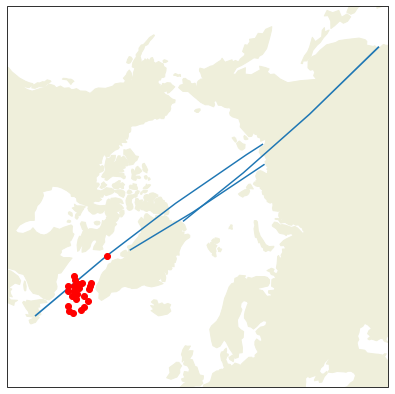

In [11]:
# Define NSIDC North Polar Stereographic projection
NSIDCNorthPolarStereo = ccrs.Stereographic(central_longitude=-45., central_latitude=90., globe=None)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180., 180., 50., 90.], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
results_gdf.to_crs("EPSG:3413").plot(ax=ax, transform=NSIDCNorthPolarStereo)
argo_gdf.plot(c='r', ax=ax, transform=ccrs.PlateCarree())

We have already seen how to get a list of urls for the data files returned by search using `tutorial_cmr.filter_urls`.  To download the files from NSIDC we use `tutorial_cmr.download`.  

Downloading files requires your EarthData username and password.  You should __never__ store login credentials in a notebook, script or program.  One way around this is to create a `.netrc` (on Unix/Linux platforms) or `_netrc` (on Windows) files.  On Unix/Linux machines, is stored in your home directory.  A simple `.netrc` file with a single entry for EarthData will look like:
```
machine urs.earthdata.nasa.gov login <your_username> password <your_password>
```

On a Windows machine it is kept in `C:\Users\"username"` and has the following format:
```
machine urs.earthdata.nasa.gov
login <your_username>
password <your_password>
```

`tutorial_cmr.download` first looks for a `netrc` file.  If it doesn't find one, it will prompt for a username and password.  So don't worry about setting one up right now.  However, it is worth doing so in the future.

In [14]:
urls = tutorial_cmr.filter_urls(search_results)
tutorial_cmr.download(urls[:2])  # Only downloads the first two files in urls

In [ ]:
# TODO plot tracks

In [ ]:
search_parameters = {
    "short_name": "MODIS_T-JPL-L2P-v2014.0",
    "temporal": "2019-01-01T00:00:00Z,2019-01-03T23:59:59Z",
}
modis_results = tutorial_cmr.search_granules(search_parameters, geojson="argo-data.geojson")

In [ ]:
for entry in modis_results["feed"]["entry"]:
    print (entry["boxes"])